<a href="https://colab.research.google.com/github/pavelpryadokhin/YOLO-sign/blob/main/YOLO_sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Применение YOLO для детекции объектов в условиях сложной освещенности.

**Автор**: [Прядохин Павел](https://github.com/pavelpryadokhin)

**Аннотация**: Целью работы является изучить методы, которые могут помочь улучшить распознавание дорожных знаков с помощью модели YOLO в условиях ограниченной видимости.

#УСТАНОВКА И ИМПОРТ БИБЛИОТЕК

In [ ]:
!pip install ultralytics > /dev/null 2>&1

In [ ]:
import kagglehub
import json
import shutil
import yaml
import os
import ultralytics
from ultralytics import YOLO, settings
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import cv2
from moviepy.editor import *
import warnings
warnings.filterwarnings('ignore')

#ТЕОРЕТИЧЕСКАЯ ЧАСТЬ

##Краткое описание проблемы

Детекция объектов в условиях сложной освещенности (низкая яркость, блики, шумы) — ключевая задача компьютерного зрения. Традиционные алгоритмы (например, классические CNN) часто ошибаются из-за:

*  Низкого контраста между объектом и фоном

*  Артефактов сенсора (шум, размытие)

*  Динамического изменения освещения

Для преодоления этих проблем предлагается использовать метод YOLO (You Only Look Once) в сочетании с аугментацией данных.

##Основные концепции

**YOLO (You Only Look Once):** Метод, который позволяет обнаруживать объекты в изображении в реальном времени. Он использует единую нейронную сеть для предсказания границ прямоугольников и классов объектов.

**Предварительная обработка изображений:** Методы улучшения изображения, такие как изменение яркости и контраста, позволяющие улучшить качество детекции.

**Аугментация данных:** Процесс увеличения объема обучающего набора данных за счет создания модифицированных версий изображений.

##Математическое обоснование

**Функция потерь YOLO:**

$$
\mathcal{L} = \lambda_{\text{coord}} \sum (x - \hat{x})^2 + \lambda_{\text{obj}} \sum (C - \hat{C})^2 + \lambda_{\text{noobj}} \sum (C - \hat{C})^2 + \sum (p - \hat{p})^2
$$

**Где:**
- $(x, C, p)$ — координаты bbox, уверенность, класс  
- $\lambda$ — весовые коэффициенты  

---
**Аугментации:**

Для пикселя $I(x,y)$:

$$
I_{\text{aug}} = \alpha I + \beta + \mathcal{N}(0, \sigma^2) \quad (\alpha = \text{контраст}, \beta = \text{яркость})
$$


##Схема архитектуры

Архитектура YOLO состоит из следующих основных компонентов:

*  **Входное изображение:** Обрабатывается через сеть свёрточных слоев.
*  **Детекция и классификация:** Происходит одновременно, обеспечивая быструю обработку.
*  **Результаты:** Содержит предсказания о местоположении и классах объектов.





# ПОДГОТОВКА ДАННЫХ

In [ ]:
# Загрузка датасета
path = kagglehub.dataset_download("watchman/rtsd-dataset")
shutil.move(path, '.')

100%|██████████| 17.1G/17.1G [03:12<00:00, 95.6MB/s]

Extracting files...


'./3'

##Предобработка

In [ ]:
# путь к датасету
root_dataset = '/content/3'

# путь к label2id словарю
labels_path = f'{root_dataset}/labels.txt'

# пути к файлам аннотаций
json_train = f'{root_dataset}/train_anno.json'
json_val = f'{root_dataset}/val_anno.json'

# путь к директории с изображениями
path_to_images = f'{root_dataset}/rtsd-frames/rtsd-frames'

# пути для формата yolo
path_yolo_dataset = './dataset'
output_train = f'{path_yolo_dataset}/train'
output_valid = f'{path_yolo_dataset}/valid'
yaml_path = f'{path_yolo_dataset}/traffic_signs.yaml'

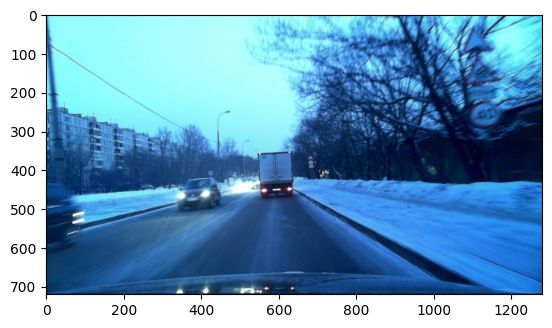

In [ ]:
# Образец изображения
image = cv2.imread('./3/rtsd-frames/rtsd-frames/autosave01_02_2012_09_13_45.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

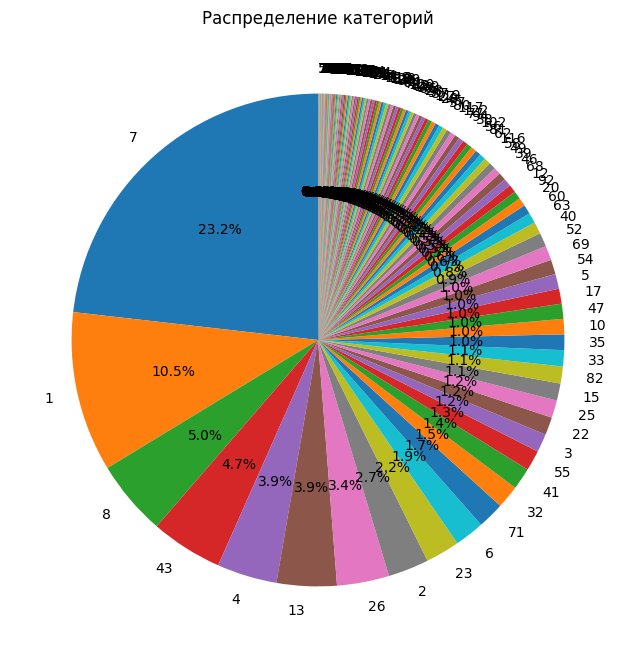

In [ ]:
# Распределение категорий в тренировочной выборке
with open(json_train, 'r', encoding='utf-8') as file:
    json_data = json.load(file)

df = pd.DataFrame(json_data['annotations'])
class_counts = df['category_id'].value_counts()
df['category_id'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(8, 8))

plt.title('Распределение категорий')
plt.ylabel('')
plt.show()

In [ ]:
def get_filter_id(df, samples_per_class= 100, min_area=0):
    df = df[df['area'] >= min_area]
    balanced_data = []

    for class_id in df['category_id'].unique():
        class_data = df[df['category_id'] == class_id]
        sample = class_data.sample(min(samples_per_class, len(class_data)),
                                   replace=False,
                                  random_state=42)
        balanced_data.append(sample)

    balanced_df = pd.concat(balanced_data)
    return balanced_df


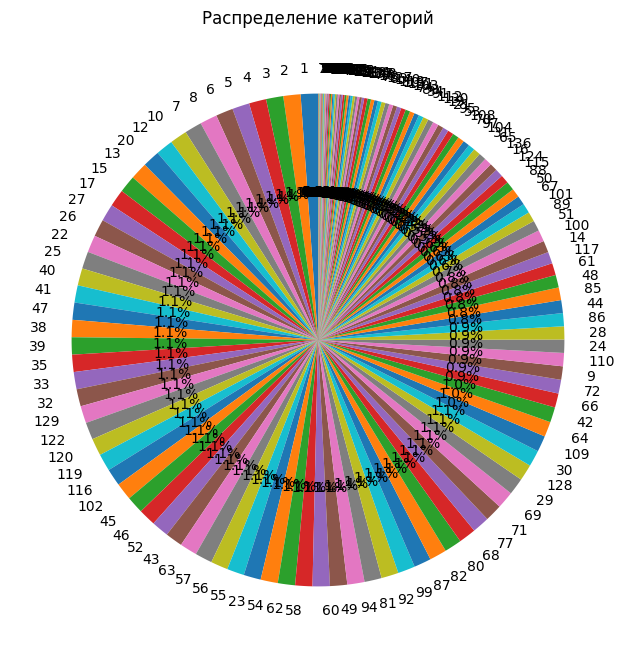

In [ ]:
# Сбалансируем классы. Отберём из каждого класса по samples_per_class примеров
# Установим минимальный размер объекта min_area для фильтрации маленьких знаков
samples_per_class = 100
min_area = 1000

balanced_df= get_filter_id(df, samples_per_class, min_area)

balanced_df['category_id'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(8, 8))

plt.title('Распределение категорий')
plt.ylabel('')
plt.show()

In [ ]:
# Важно! Для только для детекции ставим only_detect = True
# При использовании только функции обнаружения будет проигнорирована балансировка классов.
only_detect = False
filter_annotation = None

if not only_detect:
     filter_annotation = set(balanced_df['id'].to_list())

##Разделение на train/val

In [ ]:
def convert_to_yolo(data_path_json, output_dir, image_dir, filter_anno=None):
    # создаем нужные папки, если их нет
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)

    # Загрузка данных
    with open(data_path_json) as f:
        data = json.load(f)

    # Создание словаря для быстрого доступа к данным изображений
    images_info = {image['id']: image for image in data['images']}

    # Конвертация аннотаций в формат YOLO
    for ann in tqdm(data['annotations']):
        if filter_anno:
            if ann['id'] not in filter_anno:
                continue

        image_info = images_info[ann['image_id']]
        image_file_name = image_info['file_name'].split('/')[1]
        path_to_image = os.path.join(image_dir, image_file_name)

        # Проверка наличия файла изображения
        if not os.path.exists(path_to_image):
            print(image_file_name)
            continue

        # Для детекции убираем метки классов
        if filter_anno:
            category_id = 0
        else:
            category_id = ann['category_id'] - 1

        width, height = image_info['width'], image_info['height']

        # Нормализация координат баундинг бокса
        x_center = (ann['bbox'][0] + ann['bbox'][2] / 2) / width
        y_center = (ann['bbox'][1] + ann['bbox'][3] / 2) / height
        bbox_width = ann['bbox'][2] / width
        bbox_height = ann['bbox'][3] / height

        # Создание строки аннотации в формате YOLO
        yolo_format = f"{category_id} {x_center} {y_center} {bbox_width} {bbox_height}\n"

        # задаем пути для сохранения аннотации и изображения
        label_file_name = os.path.splitext(image_file_name)[0] + '.txt'
        labels_output_path = os.path.join(output_dir, 'labels', label_file_name)
        images_output_path = os.path.join(output_dir, 'images', image_file_name)

        # Запись аннотации в соответствующий файл
        with open(labels_output_path, 'a') as file:
            file.write(yolo_format)

        # копируем файл в нужную папку
        shutil.copy(path_to_image, images_output_path)

In [ ]:
convert_to_yolo(json_train,
                output_train,
                path_to_images,
                filter_annotation)

convert_to_yolo(json_val,
                output_valid,
                path_to_images)

  0%|          | 0/95492 [00:00<?, ?it/s]

  0%|          | 0/8866 [00:00<?, ?it/s]

In [ ]:
# создадим yaml file
data = {
    'path': '.'+path_yolo_dataset,
    'train': 'train/images',
    'val': 'valid/images',
}

if only_detect:
    data['names'] = {
        0: 'traffic_sign'
    }
else:
    with open(labels_path, 'r') as file:
        class_names = [line.strip() for line in file]
        id2class = dict(zip(range(len(class_names)), class_names))
        data['names'] = id2class

with open(yaml_path, 'w') as file:
    yaml.dump(data, file)

#ОБУЧЕНИЕ НА ИСХОДНЫХ ДАННЫХ

##Обучение 1-5 эпоха

In [ ]:
# уберем лишние показатели
settings.update({'tensorboard': False,
                  'wandb': False,
                  'mlflow': False,
                  'neptune': False,
                  'comet': False})

model = YOLO('yolo11s.pt')


In [ ]:
# Проведём обучение с использованием модели yolo11s и зафиксируем полученные результаты
results = model.train(
    data=yaml_path,
    epochs=5,
    batch=8,
    imgsz=1280,
    plots= True,
    device=0,
    project='TrafficSignsDetection',
    name='yolov11s_original',
    save=True,
    save_period=2
)

metrics_path = "./TrafficSignsDetection/yolov11s_original"

Ultralytics 8.3.97 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=./dataset/traffic_signs.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=1280, save=True, save_period=2, cache=False, device=0, workers=8, project=TrafficSignsDetection, name=yolov11s_original, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

100%|██████████| 755k/755k [00:00<00:00, 23.0MB/s]


Overriding model.yaml nc=80 with nc=155

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralyti

100%|██████████| 5.35M/5.35M [00:00<00:00, 98.1MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/train/labels... 7844 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7844/7844 [00:06<00:00, 1151.56it/s]


train: New cache created: /content/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/valid/labels... 5000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:03<00:00, 1536.80it/s]


val: New cache created: /content/dataset/valid/labels.cache
Plotting labels to TrafficSignsDetection/yolov11s_original/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=6.3e-05, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to TrafficSignsDetection/yolov11s_original
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.01G     0.9683      7.198     0.9464          4       1280: 100%|██████████| 981/981 [11:22<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [02:06<00:00,  2.47it/s]

                   all       5000       8866    0.00196     0.0134    0.00156    0.00122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.42G     0.8912      2.113        0.9          6       1280: 100%|██████████| 981/981 [10:40<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:52<00:00,  2.79it/s]

                   all       5000       8866    0.00151    0.00989    0.00132    0.00101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.46G       0.87      1.437     0.8932          6       1280: 100%|██████████| 981/981 [10:16<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:44<00:00,  2.99it/s]


                   all       5000       8866     0.0014    0.00811    0.00119    0.00086

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       9.5G      0.852      1.149     0.8853          9       1280: 100%|██████████| 981/981 [10:27<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [02:04<00:00,  2.52it/s]

                   all       5000       8866     0.0942    0.00433   0.000756   0.000552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.54G     0.8336      1.009     0.8848          8       1280: 100%|██████████| 981/981 [10:34<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


                   all       5000       8866      0.145    0.00464    0.00109   0.000864

5 epochs completed in 1.056 hours.
Optimizer stripped from TrafficSignsDetection/yolov11s_original/weights/last.pt, 19.4MB
Optimizer stripped from TrafficSignsDetection/yolov11s_original/weights/best.pt, 19.4MB

Validating TrafficSignsDetection/yolov11s_original/weights/best.pt...
Ultralytics 8.3.97 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,472,785 parameters, 0 gradients, 21.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


                   all       5000       8866    0.00197     0.0134    0.00156    0.00122
                   2_1        929        934      0.022      0.964     0.0702     0.0482
                  1_23        225        229          0          0          0          0
                  1_17        103        107          0          0          0          0
                  3_24        319        343          0          0          0          0
                 8_2_1         74         74          0          0          0          0
                  5_20        148        154          0          0          0          0
                5_19_1       1311       2117          0          0          0          0
                  5_16        424        445     0.0747     0.0742     0.0409     0.0306
                  3_25         10         10          0          0          0          0
                  6_16         97         97          0          0          0          0
                  7_1

##Метрики(5 эпох)

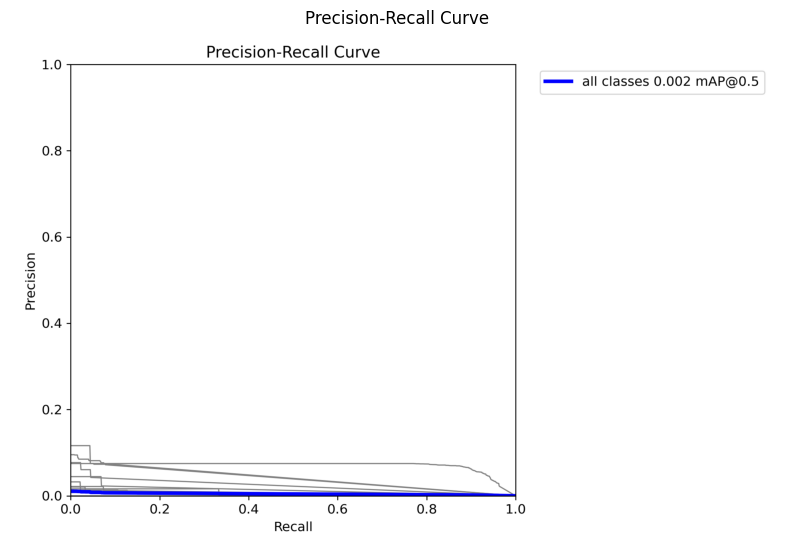

In [ ]:
# Precision-Recall кривые
precision_recall_curve = f"{metrics_path}/PR_curve.png"
img = plt.imread(precision_recall_curve)
plt.figure(figsize=(10, 8))
plt.title("Precision-Recall Curve")
plt.imshow(img)
plt.axis('off')
plt.show()

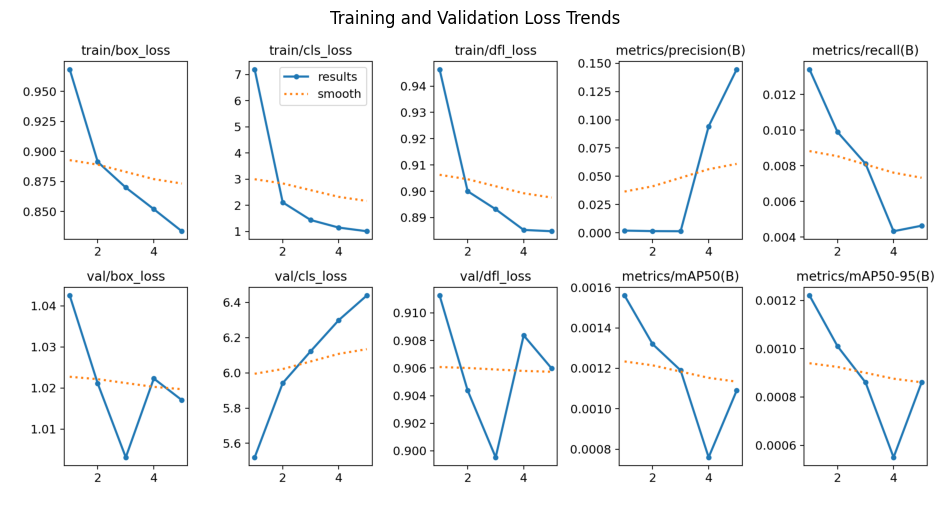

In [ ]:
# Loss Graphs (Loss, Precision, Recall, mAP@0.5)
loss_graph = f"{metrics_path}/results.png"
img = plt.imread(loss_graph)
plt.figure(figsize=(12, 8))
plt.title("Training and Validation Loss Trends")
plt.imshow(img)
plt.axis('off')
plt.show()

##Обучение 5-10 эпоха

In [ ]:
model_2 = YOLO('./TrafficSignsDetection/yolov11s_original/weights/best.pt')
results_2 = model_2.train(
    data=yaml_path,
    epochs=5,
    batch=8,
    imgsz=1280,
    plots= True,
    device=0,
    project='TrafficSignsDetection',
    name='yolov11s_original_2',
    save=True,
    save_period=2,
)
metrics_path = "./TrafficSignsDetection/yolov11s_original_2"

Ultralytics 8.3.97 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=./TrafficSignsDetection/yolov11s_original/weights/best.pt, data=./dataset/traffic_signs.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=1280, save=True, save_period=2, cache=False, device=0, workers=8, project=TrafficSignsDetection, name=yolov11s_original_2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, sav

train: Scanning /content/dataset/train/labels.cache... 7844 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7844/7844 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/valid/labels.cache... 5000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


Plotting labels to TrafficSignsDetection/yolov11s_original_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=6.3e-05, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to TrafficSignsDetection/yolov11s_original_2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.02G     0.8596       2.17     0.8944          4       1280: 100%|██████████| 981/981 [10:41<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:53<00:00,  2.75it/s]

                   all       5000       8866    0.00179    0.00864    0.00133    0.00104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.43G     0.8787      1.385     0.8958          6       1280: 100%|██████████| 981/981 [10:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:48<00:00,  2.89it/s]


                   all       5000       8866    0.00171    0.00764    0.00135    0.00107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.47G     0.8613      1.047     0.8908          6       1280: 100%|██████████| 981/981 [10:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:46<00:00,  2.95it/s]


                   all       5000       8866     0.0581    0.00479   0.000548    0.00039

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.51G     0.8459     0.8885     0.8827          9       1280: 100%|██████████| 981/981 [10:12<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:44<00:00,  3.00it/s]


                   all       5000       8866      0.051    0.00415   0.000558   0.000405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.51G     0.8262     0.8012     0.8826          8       1280: 100%|██████████| 981/981 [10:13<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:45<00:00,  2.96it/s]

                   all       5000       8866     0.0726    0.00451   0.000816   0.000598



5 epochs completed in 1.015 hours.
Optimizer stripped from TrafficSignsDetection/yolov11s_original_2/weights/last.pt, 19.4MB
Optimizer stripped from TrafficSignsDetection/yolov11s_original_2/weights/best.pt, 19.4MB

Validating TrafficSignsDetection/yolov11s_original_2/weights/best.pt...
Ultralytics 8.3.97 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,472,785 parameters, 0 gradients, 21.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:37<00:00,  3.20it/s]


                   all       5000       8866    0.00172    0.00764    0.00135    0.00107
                   2_1        929        934     0.0296      0.956     0.0766     0.0532
                  1_23        225        229          0          0          0          0
                  1_17        103        107          0          0          0          0
                  3_24        319        343          0          0          0          0
                 8_2_1         74         74          0          0          0          0
                  5_20        148        154          0          0          0          0
                5_19_1       1311       2117          0          0          0          0
                  5_16        424        445          0          0          0          0
                  3_25         10         10          0          0          0          0
                  6_16         97         97          0          0          0          0
                  7_1

##Метрики(5-10 эпоха)

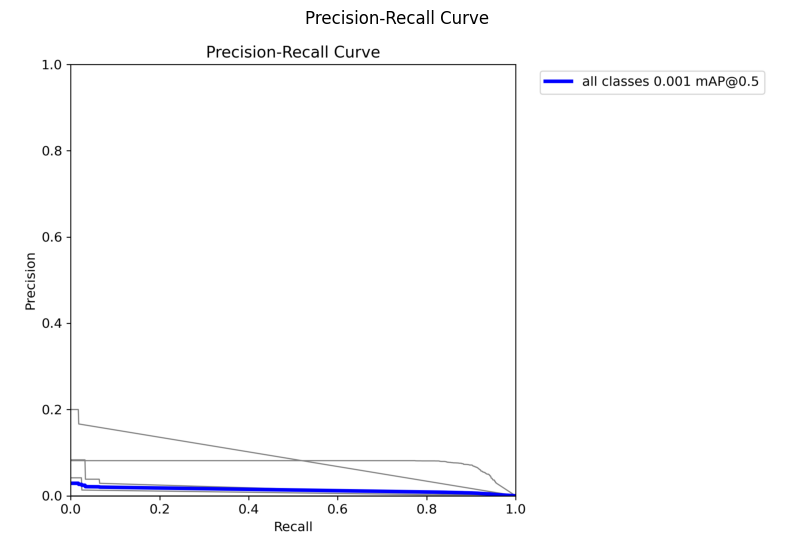

In [ ]:
# Precision-Recall кривые
precision_recall_curve = f"{metrics_path}/PR_curve.png"
img = plt.imread(precision_recall_curve)
plt.figure(figsize=(10, 8))
plt.title("Precision-Recall Curve")
plt.imshow(img)
plt.axis('off')
plt.show()

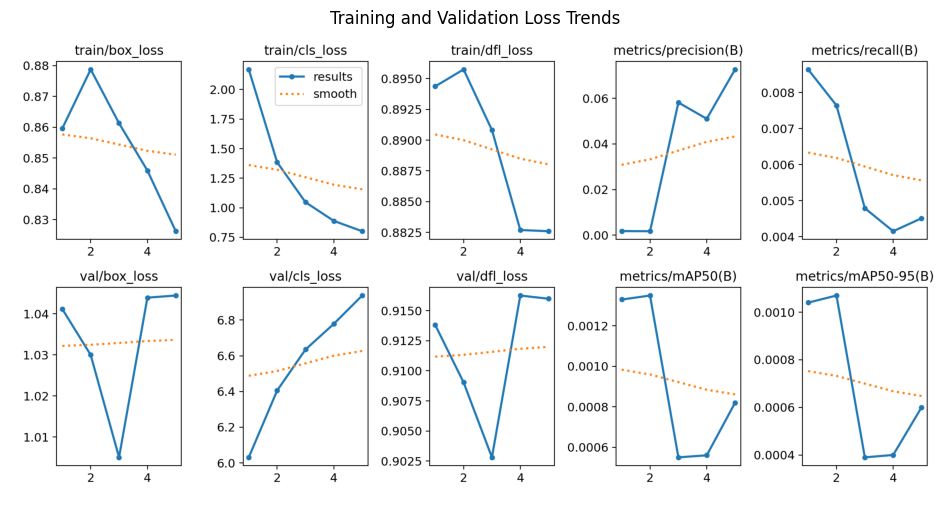

In [ ]:
# Loss Graphs (Loss, Precision, Recall, mAP@0.5)
loss_graph = f"{metrics_path}/results.png"
img = plt.imread(loss_graph)
plt.figure(figsize=(12, 8))
plt.title("Training and Validation Loss Trends")
plt.imshow(img)
plt.axis('off')
plt.show()

##Визуализация работы

In [ ]:
example_video_path = './Видео_тест.mp4'
model_best = YOLO("./TrafficSignsDetection/yolov11s_original_2/weights/best.pt")

video_output = model_best.predict(source=example_video_path, conf=0.6, save=True)

In [ ]:
path="./runs/detect/predict5/Видео_тест.avi"

clip=VideoFileClip(path)
clip.ipython_display(width=960)


image 1/1 /content/тест.jpeg: 864x1280 4 2_1s, 50.4ms
Speed: 22.0ms preprocess, 50.4ms inference, 367.7ms postprocess per image at shape (1, 3, 864, 1280)
Results saved to runs/detect/predict6
1 label saved to runs/detect/predict6/labels


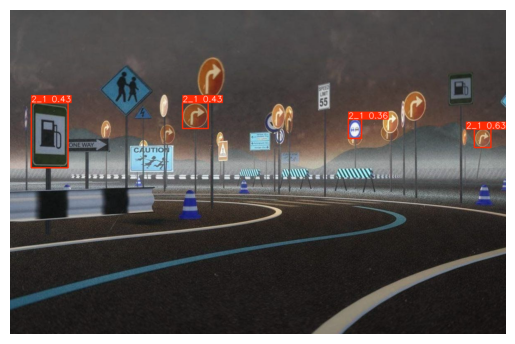

In [ ]:
image_test_path = './тест.jpeg'
pred = model_best.predict(source=image_test_path,
                         save=True, save_txt=True)

test_image = pred[0].plot(line_width=2)
plt.axis('off')
plt.imshow(test_image)

#АУГМЕНТЦАЦИЯ ДАННЫХ

In [ ]:
# Cкопируем датасет для аугментации данных.
folder = path_yolo_dataset
new_folder = './augmentation_dataset'
shutil.copytree(folder,new_folder)

# Пути к данным
images_dir = f"{new_folder}/train/images"
labels_dir = f"{new_folder}/train/labels"

# Создаем новые папки для аугментированных данных
images_aug_dir = f"{new_folder}/train_aug/images"
labels_aug_dir = f"{new_folder}/train_aug/labels"
os.makedirs(images_aug_dir, exist_ok=True)
os.makedirs(labels_aug_dir, exist_ok=True)

In [ ]:
# Аугментация изображений
transform = A.Compose([
    A.RandomBrightnessContrast(
        brightness_limit=(-0.3, 0),   # Уменьшаем яркость, но не до полной темноты
        contrast_limit=(-0.2, 0),     # Уменьшаем контраст
        p=0.8
    ),
    A.GaussianBlur(blur_limit=(1, 3), p=0.3),  # Небольшое размытие для реалистичности
    A.HueSaturationValue(
        hue_shift_limit=10,
        sat_shift_limit=(-40, -20),    # Уменьшаем насыщенность, чтобы имитировать ночные условия
        val_shift_limit=(-30, -10),     # Уменьшаем значение (делаем изображение темнее)
        p=0.5
    ),
    A.RandomGamma(
        gamma_limit=(30, 70),           # Уменьшаем гамму для темных изображений
        p=0.5
    ),
    A.ISONoise(
        color_shift=(0.01, 0.05),       # Немного увеличиваем шум на изображении
        intensity=(0.05, 0.15),         # Увеличиваем интенсивность шума для реалистичности
        p=0.5
    ),
])


In [ ]:
def augmentation(transform,images_dir,labels_dir,images_aug_dir,labels_aug_dir):
    # Проходим по всем изображениям
    for image_name in tqdm(os.listdir(images_dir)):

        # Пропускаем не-изображения
        if not image_name.lower().endswith('.jpg'):
            continue

        # Загружаем изображение
        image_path = os.path.join(images_dir, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Применяем аугментацию
        augmented_image = transform(image=image)["image"]

        # Сохраняем аугментированное изображение
        new_image_path = os.path.join(images_aug_dir, 'aug_'+image_name)
        cv2.imwrite(new_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

        # Копируем соответствующий файл разметки
        label_name = os.path.splitext(image_name)[0] + ".txt"
        label_path = os.path.join(labels_dir, label_name)
        new_label_path = os.path.join(labels_aug_dir, 'aug_'+label_name)
        shutil.copy(label_path, new_label_path)

    print(f'Файлов в папке images: {len(os.listdir(images_aug_dir))}')
    print(f'Файлов в папке labels: {len(os.listdir(labels_aug_dir))}')

In [ ]:
augmentation(transform,
             images_dir,labels_dir,
             images_aug_dir,labels_aug_dir)

  0%|          | 0/7844 [00:00<?, ?it/s]

Файлов в папке images: 7844
Файлов в папке labels: 7844


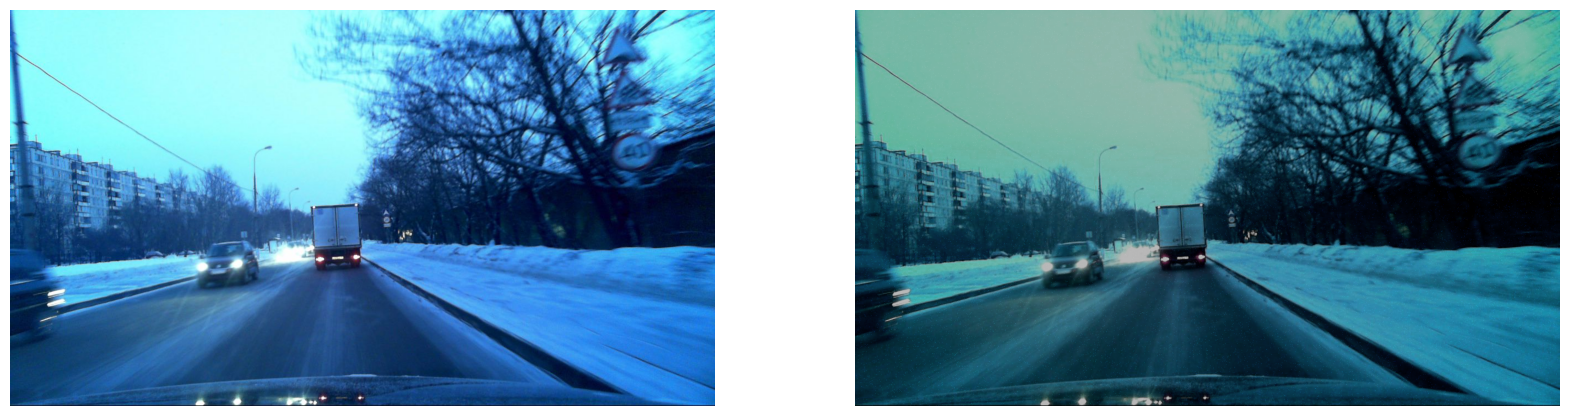

In [ ]:
image = cv2.imread(f'{new_folder}/train/images/autosave01_02_2012_09_13_45.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

augmented = transform(image=image)["image"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=100)
ax1.imshow(image)
ax2.imshow(augmented)
[ax.axis('off') for ax in [ax1, ax2]]
plt.show()

In [ ]:
#исправим yaml file
data = {
    'path': '.'+new_folder,
    'train': 'train_aug/images',
    'val': 'valid/images',
}

if only_detect:
    data['names'] = {
        0: 'traffic_sign'
    }
else:
    with open(labels_path, 'r') as file:
        class_names = [line.strip() for line in file]
        id2class = dict(zip(range(len(class_names)), class_names))
        data['names'] = id2class

yaml_path_aug = f'{new_folder}/traffic_signs.yaml'
with open(yaml_path_aug, 'w') as file:
    yaml.dump(data, file)

#ДООБУЧЕНИЕ НА АУГМЕНТИРОВАННЫХ ДАННЫХ

In [ ]:
# model_aug = YOLO("./TrafficSignsDetection/yolov11s_original/weights/best.pt")
model_aug = YOLO('/content/best_yolo11s_5_epochs.pt')

In [ ]:
# Проведём обучение с использованием модели yolo11s и зафиксируем полученные результаты
results_aug = model_aug.train(
    data=yaml_path_aug,
    epochs=5,
    batch=8,
    imgsz=1280,
    plots= True,
    device=0,
    project='TrafficSignsDetection',
    name='yolov11s_aug',
    save=True,
    save_period=2
)

metrics_path = "./TrafficSignsDetection/yolov11s_aug"

Ultralytics 8.3.98 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/best_yolo11s_5_epochs.pt, data=./augmentation_dataset/traffic_signs.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=1280, save=True, save_period=2, cache=False, device=0, workers=8, project=TrafficSignsDetection, name=yolov11s_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

100%|██████████| 755k/755k [00:00<00:00, 23.5MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

100%|██████████| 5.35M/5.35M [00:00<00:00, 94.1MB/s]


AMP: checks passed ✅


train: Scanning /content/augmentation_dataset/train_aug/labels... 7844 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7844/7844 [00:04<00:00, 1939.43it/s]


train: New cache created: /content/augmentation_dataset/train_aug/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/augmentation_dataset/valid/labels... 5000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:10<00:00, 469.56it/s]


val: New cache created: /content/augmentation_dataset/valid/labels.cache
Plotting labels to TrafficSignsDetection/yolov11s_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=6.3e-05, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to TrafficSignsDetection/yolov11s_aug
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.25G       0.92      2.315     0.9169          4       1280: 100%|██████████| 981/981 [10:56<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [02:01<00:00,  2.58it/s]

                   all       5000       8866    0.00248    0.00887    0.00173    0.00139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.66G     0.9225      1.453     0.9119          6       1280: 100%|██████████| 981/981 [10:54<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


                   all       5000       8866     0.0796    0.00637   0.000982   0.000781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       9.7G     0.9029      1.103     0.9063          6       1280: 100%|██████████| 981/981 [10:56<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:51<00:00,  2.81it/s]


                   all       5000       8866     0.0509     0.0042   0.000612   0.000455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.74G     0.8821     0.9352     0.8983          9       1280: 100%|██████████| 981/981 [10:59<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [02:12<00:00,  2.37it/s]


                   all       5000       8866     0.0726     0.0044   0.000586   0.000423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.79G     0.8634      0.846      0.895          8       1280: 100%|██████████| 981/981 [10:21<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:49<00:00,  2.87it/s]


                   all       5000       8866     0.0582    0.00453      0.001   0.000721

5 epochs completed in 1.069 hours.
Optimizer stripped from TrafficSignsDetection/yolov11s_aug/weights/last.pt, 19.4MB
Optimizer stripped from TrafficSignsDetection/yolov11s_aug/weights/best.pt, 19.4MB

Validating TrafficSignsDetection/yolov11s_aug/weights/best.pt...
Ultralytics 8.3.98 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,472,785 parameters, 0 gradients, 21.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:41<00:00,  3.09it/s]


                   all       5000       8866     0.0024    0.00887     0.0017    0.00136
                   2_1        929        934     0.0337      0.941     0.0732     0.0515
                  1_23        225        229          0          0          0          0
                  1_17        103        107          0          0          0          0
                  3_24        319        343          0          0          0          0
                 8_2_1         74         74          0          0          0          0
                  5_20        148        154          0          0          0          0
                5_19_1       1311       2117          0          0          0          0
                  5_16        424        445      0.143    0.00449     0.0725     0.0652
                  3_25         10         10          0          0          0          0
                  6_16         97         97          0          0          0          0
                  7_1

##Метрики

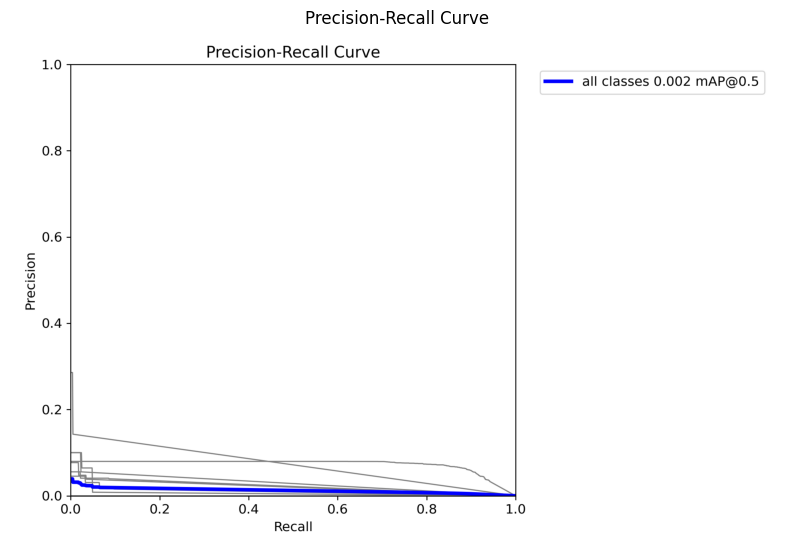

In [ ]:
# Precision-Recall кривые
precision_recall_curve = f"{metrics_path}/PR_curve.png"
img = plt.imread(precision_recall_curve)
plt.figure(figsize=(10, 8))
plt.title("Precision-Recall Curve")
plt.imshow(img)
plt.axis('off')
plt.show()

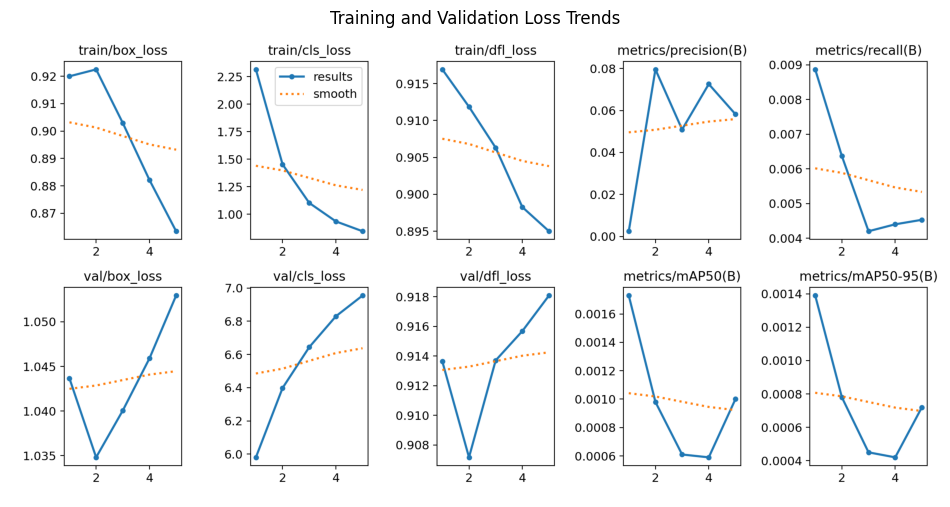

In [ ]:
# Loss Graphs (Loss, Precision, Recall, mAP@0.5)
loss_graph = f"{metrics_path}/results.png"
img = plt.imread(loss_graph)
plt.figure(figsize=(12, 8))
plt.title("Training and Validation Loss Trends")
plt.imshow(img)
plt.axis('off')
plt.show()

##Визуализация работы

In [ ]:
example_video_path = './Видео_тест.mp4'
model_aug_best = YOLO("./TrafficSignsDetection/yolov11s_aug/weights/best.pt")

video_output = model_aug_best.predict(source=example_video_path, conf=0.6, save=True)

In [ ]:
path="./runs/detect/predict2/Видео_тест.avi"

clip=VideoFileClip(path)
clip.ipython_display(width=960)


image 1/1 /content/тест.jpeg: 864x1280 6 2_1s, 51.6ms
Speed: 9.5ms preprocess, 51.6ms inference, 1.6ms postprocess per image at shape (1, 3, 864, 1280)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


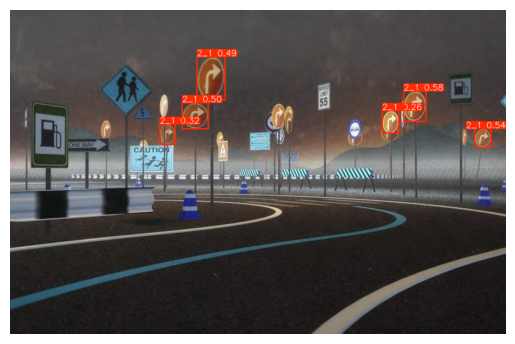

In [ ]:
image_test_path = './тест.jpeg'
pred = model_aug_best.predict(source=image_test_path,
                         save=True, save_txt=True)

test_image = pred[0].plot(line_width=2)
plt.axis('off')
plt.imshow(test_image)

#ВЫВОДЫ

##Основные результаты


*  В ходе исследования были изучены различные методы аугментации данных, которые способны повысить точность распознавания дорожных знаков в условиях ограниченной видимости. Эти методы сравнивались с группой, которая была обучена на данных без аугментации.

*  В частности, применялись техники изменения яркости, контрастности, размытости и насыщенности изображений. Благодаря этому модель YOLO стала более точно определять объекты даже в сложных условиях освещения.

*  Результаты исследования подтверждают, что аугментация данных является важным инструментом для повышения точности работы моделей, используемых для детекции.

##Проблемы и ограничения

При реализации проекта следует учитывать ряд ограничений, главным из которых являются вычислительные ресурсы. Сложность модели и необходимость обработки большого объема данных требуют значительных вычислительных мощностей. Если их не хватает, это может сказаться на качестве распознавания объектов, что негативно отразится на итоговых результатах работы системы.

##Возможные улучшения

Для дальнейшего повышения качества распознавания дорожных знаков можно рассмотреть несколько дополнительных подходов.
*   Одним из таких методов является использование аугментации для создания недостающих данных вместо их обрезки. Это позволит улучшить обилие разнообразных изображений в обучающей выборке.
*  Также целесообразно добавлять дополнительные знаки на существующие изображения и экспериментировать с заменой изображений знаков.

Данные практики могут привести к повышению общей надежности и точности работы модели YOLO в условиях сложного освещения.